# Loading of Libraries and Classes

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from MonteCarloSimulators.CIR.CIRMCSim import MC_CIR_Sim
from Scheduler.Scheduler import Scheduler
from Products.Credit.CDS import CDS
from Curves.OIS.OIS import OIS
from Calibration.CIR_calibrate import CIRLambdaCalibration
from Products.Credit.CDS_Swaption import CDSSwaption
from Products.Credit.CDS_exposure import CDS_exposure

# Parameters

In [105]:
option_start = date(2010,1,10)
cds_start = date(2011,1,10)
cds_end = date(2016,1,10)
Recovery = 0.4
initial_lambda = 0.03
# initial_guess = np.array([1,1,0.13])
initial_guess = np.array([1,0.1,0.03])
market_tenorList = np.array([6/12,1,2,3,4,5,7,10])
# market_spread = 0.0001*np.array([39.3, 40.40, 71.465, 130, 202.25, 265.433, 346.885, 378.250])
# market_spread = 0.0001*np.array([43.2, 40.40, 71.465, 130, 202.25, 265.433, 346.885, 378.250])
# market_spread = 0.0001*np.array([39.3, 40.40, 71.465, 143, 202.25, 265.433, 346.885, 378.250]) 
market_spread = 0.0001*np.array([39.3, 40.40, 71.465, 130, 202.25, 265.433, 346.885, 416.075])
# market_spread = 0.0001 * np.array([12.1, 13.6, 20.0, 24.8, 31.1, 35, 72.9, 121.1])
t_step = 1.0/365
simNumber = 30

# OIS

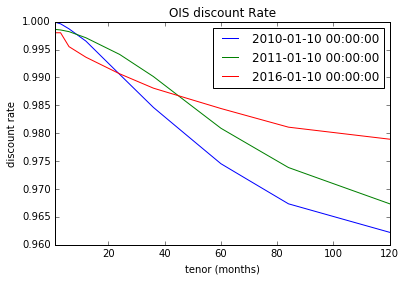

In [106]:
myois = OIS(option_start, cds_end)
mymthois = myois.getDiscountFactor()
df1 = pd.DataFrame(mymthois.loc[option_start], index=mymthois.columns)
df2 = pd.DataFrame(mymthois.loc[cds_start], index=mymthois.columns)
df3 = pd.DataFrame(mymthois.loc[cds_end], index=mymthois.columns)
df4 = pd.concat([df1,df2,df3],axis=1)
df_plot = df4.plot()
df_plot.set_xlabel('tenor (months)')
df_plot.set_ylabel('discount rate')
df_plot.set_title('OIS discount Rate')

# Calibrate hazard rate using CIR

In [107]:
MyCal = CIRLambdaCalibration(option_start, cds_end)
MyPara = MyCal.getCalibratedParameters(initial_lambda, initial_guess, market_tenorList, market_spread)
MyPara

array([ 0.08868722,  0.1006246 ,  0.09230542])

# Hazard rate and Survival curve single path simulation

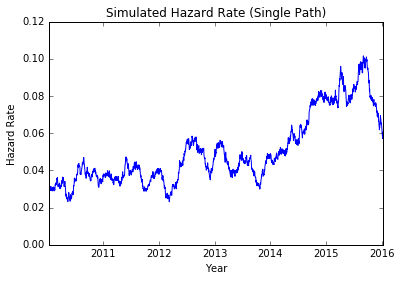

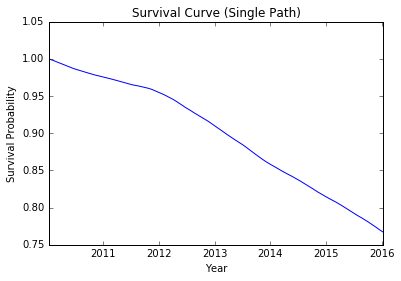

In [108]:
Mysim_SinglePath = MC_CIR_Sim()
initial_guess_new = np.append(MyPara, [initial_lambda])
Mysim_SinglePath.setCIR(option_start, cds_end, initial_guess_new, 1, t_step)
MyQ_SinglePath = Mysim_SinglePath.getSurvival_daily()
hazard_SinglePath = Mysim_SinglePath.getHazard_daily()
hazard_graph_S = hazard_SinglePath.plot(legend=False)
hazard_graph_S.set_xlabel('Year')
hazard_graph_S.set_ylabel('Hazard Rate')
hazard_graph_S.set_title('Simulated Hazard Rate (Single Path)')
MyQ_graph_S = MyQ_SinglePath.plot(legend=False)
MyQ_graph_S.set_xlabel('Year')
MyQ_graph_S.set_ylabel('Survival Probability')
MyQ_graph_S.set_title('Survival Curve (Single Path)')

# Hazard rate and Survival curve multi paths simulation (Sim_Number = 30)

In [109]:
Mysim = MC_CIR_Sim()
initial_guess_new = np.append(MyPara, [initial_lambda])
Mysim.setCIR(option_start, cds_end, initial_guess_new, simNumber, t_step)
MyQ = Mysim.getSurvival_daily()
hazard = Mysim.getHazard_daily()
# MyQ

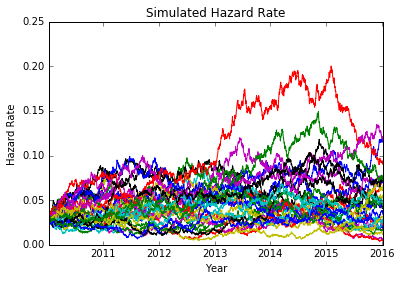

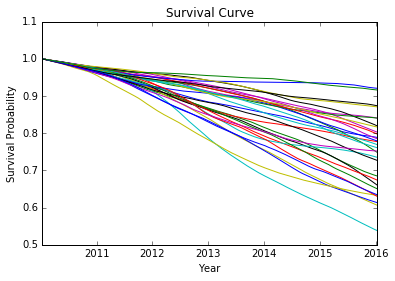

In [110]:
hazard_graph = hazard.plot(legend=False)
hazard_graph.set_xlabel('Year')
hazard_graph.set_ylabel('Hazard Rate')
hazard_graph.set_title('Simulated Hazard Rate')
MyQ_graph = MyQ.plot(legend=False)
MyQ_graph.set_xlabel('Year')
MyQ_graph.set_ylabel('Survival Probability')
MyQ_graph.set_title('Survival Curve')

# Pricing default swaption

In [111]:
MySwaptionPayer_price = np.array([])
MySwaptionReceiver_price = np.array([])
strikes = np.array([0,100,200,300,400,500,600])*0.0001
for i in strikes:
    MySwaptionPayer = CDSSwaption(option_start, cds_start, cds_end, i, "3M", 1, Recovery, MyQ)
    MySwaptionReceiver = CDSSwaption(option_start, cds_start, cds_end, i, "3M", 0, Recovery, MyQ)
    #tempSwaptionValuePayer = tempSwaptionPayer.getCDSSwaption(i)
    #tempSwaptionValueReceiver = tempSwaptionReceiver.getCDSSwaption(i)
    tempPayer = MySwaptionPayer.getCDSSwaption(i)
    tempReceiver = MySwaptionReceiver.getCDSSwaption(i)
    MySwaptionPayer_price = np.append(MySwaptionPayer_price, tempPayer)
    MySwaptionReceiver_price = np.append(MySwaptionReceiver_price, tempReceiver)

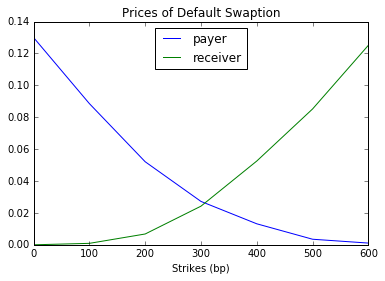

In [112]:
Swaption_prices = np.array([MySwaptionPayer_price, MySwaptionReceiver_price])
Swaption_prices = pd.DataFrame(data=Swaption_prices.transpose(), index=strikes*10000, columns=["payer","receiver"])
Swaption_prices_Graph = Swaption_prices.plot()
Swaption_prices_Graph.set_xlabel('Strikes (bp)')
Swaption_prices_Graph.set_ylabel('')
Swaption_prices_Graph.set_title('Prices of Default Swaption')

In [113]:
Swaption_prices

,payer,receiver
0.0,0.129999,0.000000
100.0,0.088566,0.000909
200.0,0.052097,0.006781
300.0,0.027209,0.024235
400.0,0.013172,0.052540
500.0,0.003491,0.085201
600.0,0.001084,0.125136


# exposures for CDS

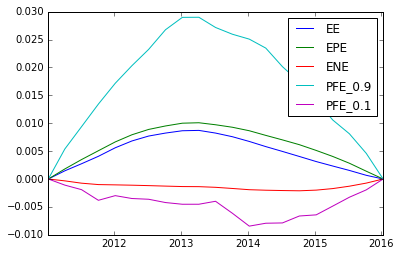

In [114]:
Mysim_exposure = MC_CIR_Sim()
initial_guess_new = np.append(MyPara, [initial_lambda])
# initial_guess_new = np.append(initial_guess, [initial_lambda])
Mysim_exposure.setCIR(option_start, cds_end, initial_guess_new, 30, t_step)
MyQ_exposure = Mysim_exposure.getSurvival_daily()
myexposure = CDS_exposure(MyQ_exposure, cds_start, cds_end, "3M", 1, recovery=0.4)
Exposure = [myexposure.getEE(),myexposure.getEPE(), myexposure.getENE(), myexposure.getPFE(0.9), myexposure.getPFE(0.1)]
Exp = pd.concat(Exposure,axis=1)
Exp.plot()

In [115]:
myexposure.getCVA()

array([ 0.06546717])

In [116]:
#myexposure.getParspread_single(MyQ_exposure[0])

0.037360732014909789

In [117]:
#myexposure.getParspread_ave()

(0.028053050984444498, 0.013666412487988583)